In [1]:
import os,re,sys,pickle,datetime,time,random,itertools
import warnings
warnings.filterwarnings("ignore")
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation, PillowWriter
jet = plt.get_cmap('jet')
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy import stats, array
import math
from tqdm import tqdm
import seaborn as sns 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA,NMF
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest,f_regression,mutual_info_regression
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LogisticRegression,Lasso,LinearRegression,Ridge,ElasticNetCV,ElasticNet,Lars,LassoCV,RidgeCV,LarsCV,LassoLarsCV,LassoLarsIC,OrthogonalMatchingPursuitCV,OrthogonalMatchingPursuit
from sklearn.manifold import TSNE,MDS
from sklearn import metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,median_absolute_error, silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedKFold,LeaveOneOut
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures
from sklearn.svm import LinearSVC,SVR
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
import loo_q2 as loo
randomstate = 42
import rdkit
from rdkit import Chem, RDConfig
from rdkit.Chem import AllChem, MolFromSmiles, PandasTools, Descriptors, PropertyMol, Draw, rdmolfiles, rdFMCS
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Draw import MolsToGridImage, IPythonConsole, rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import MolDrawing,DrawingOptions, Font
DrawingOptions.bondLineWidth=1.8
DrawingOptions.includeAtomNumbers=False
size = (150, 150)
import kennardstonealgorithm 
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import # Fixing random state for reproducibility

# Load data

In [2]:
ci = pd.read_excel('example_descriptors.xlsx','descriptors',index_col=0,header=1,engine='openpyxl')
compinp = ci[ci.columns[1:-3]].loc[ci.index[:]]
compinp.index = compinp.index.astype(int)
compinp.dropna(axis=0,inplace=True)

inp2 = pd.read_excel("example_identifiers.xlsx",index_col=1,header=2,engine='openpyxl')
inp2.index = inp2.index.astype(int)

print(len(inp2.index),'ligands in identifiers file')
print(len(compinp.index),'ligands in descriptors file')

**Remove colinear descriptors and remove descriptors with all values = 0 (optional)**

If a pair of descriptors have an Pearson correlation coefficient (r) value greater than the threshold one descriptor will be removed.

In [3]:
threshold = 0.95

print('Shape of descriptors file before curation: ',compinp.shape)
#compinp = compinp.astype(float)
df_corr = compinp.corr()
df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > threshold).any()
un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
compinp = compinp[un_corr_idx]

compinp = compinp.loc[:, (compinp != 0).any(axis=0)]

print('Shape of descriptors file after curation: ',compinp.shape)

Shape of descriptors file before curation:  (1544, 190)
Shape of descriptors file after curation:  (1544, 139)


**Create subsets from the identifiers file and scale the data**
- Create sets of descriptors
- Create sets of ligand IDs (only contain IDs for ligands that have descriptors)

In [4]:
X_all = np.array(compinp)
X_com = np.array(compinp.loc[inp2["COM"]==1])
X_sigma = np.array(compinp.loc[inp2["sigma"]==1])

X_all_ids = np.array(compinp.index)
X_com_ids = np.array(compinp.loc[inp2["COM"]==1].index)
X_sigma_ids = np.array(compinp.loc[inp2["sigma"]==1].index)

scaler = StandardScaler()
scaler.fit(X_all)
#scaler.fit(X_com)

X_all_sc    = scaler.transform(X_all)
X_com_sc    = scaler.transform(X_com)
X_sigma_sc = scaler.transform(X_sigma)

**Run the PCA**

In [10]:
pca = PCA(n_components=4)
pca.fit(X_all_sc)

X_all_pca    = pca.transform(X_all_sc)
X_com_pca    = pca.transform(X_com_sc)
X_sigma_pca   = pca.transform(X_sigma_sc)

pca_score = pca.explained_variance_ratio_
pca_values = pca.singular_values_
V = pca.components_

# PCA information

**General information**

In [11]:
# explained variance
print('Total variance explained by PCs:',round(np.sum(pca.explained_variance_ratio_*100),1),'%\n')
print("Percentage of explained variance per principal component")
for i,j in enumerate(pca_score):
    print(f"PC{i+1}   {j*100:.1f}%")

Total variance explained by PCs: 57.1 %

Percentage of explained variance per principal component
PC1   26.8%
PC2   13.2%
PC3   11.0%
PC4   6.2%


**Scree plot**

A scree plot shows how much variation each PC captures from the data. An ideal curve should be steep, then bends at an “elbow” — this is your cutting-off point — and after that flattens out. Use a scree plot to select the principal components to keep. If the first two or three PCs capture most of the information (80% of variance as a guideline), we can ignore the rest without losing anything important. If you need too many PCs then consider other dimension reduction techniques.

Running this code will override the number of PCs designated above.

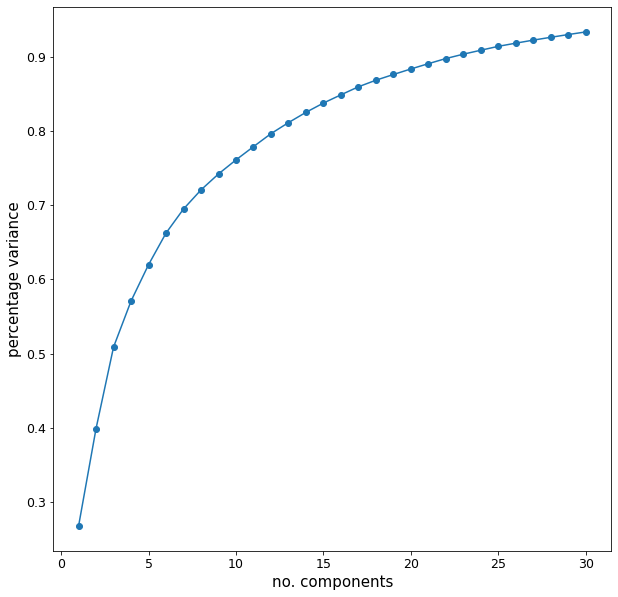

In [7]:
subset = X_all_sc

points = []
for i in range(1,31):
    pca = PCA(n_components=i)
    crds = pca.fit_transform(subset)
    var = np.sum(pca.explained_variance_ratio_)
    points.append([i,var])

data = np.array(points)
x, y = data.T
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12.5) , plt.yticks(fontsize=12.5)
plt.xlabel("no. components",fontsize=15), plt.ylabel("percentage variance",fontsize=15)
plt.plot(x,y,zorder=2)
plt.scatter(x,y,zorder=1)
plt.show()
#plt.savefig("explained_variance.png",dpi=300)

**Loading plot/correlation circle (often found within a 'PCA biplot')**

(1) Use the point at the end of the vector to determine how much weight the descriptor has on the PCs. The further away these vectors are from the origin, the more influence they have on that PC.

(2) The angles between the vectors indicate how the descriptors correlate with one another. When two vectors are close, forming a small angle, the two variables are positively correlated. A 90° angle signifies they are not likely to be correlated. When a large angle is formed (close to 180°), the descriptors are negative correlated.

PCA "loadings" are the coefficients of the linear combination of variables from which the principal components are constructed. They indicate how much each variable contributes to the PC, and can range from -1 to 1. Loadings close to -1 or 1 indicate that the variable strongly influences the component. Loadings close to 0 indicate that the variable has a weak influence on the component. Evaluating the loadings can help characterize each component in terms of the variables. Loadings can be found using 'pca.components_'

Note the scale needs manual adjusting and feature names not fixed.

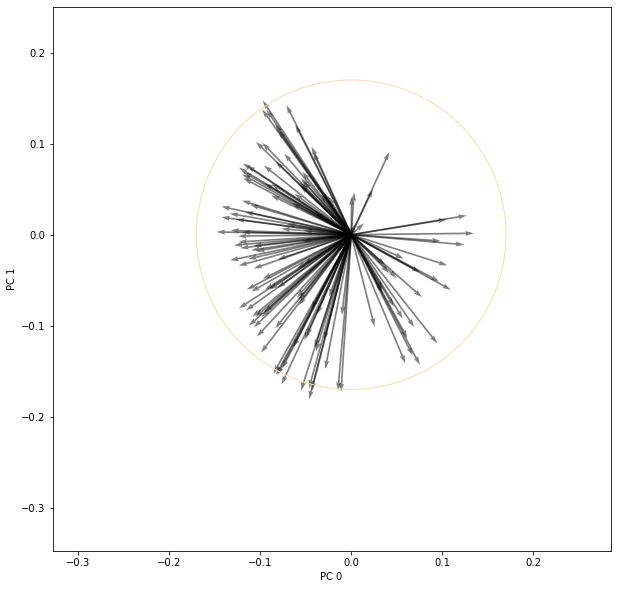

In [8]:
### Get the PCA components (loadings)
PCs = pca.components_

### Use quiver to generate the basic plot
fig = plt.figure(figsize=(10,10))
plt.quiver(np.zeros(PCs.shape[1]), np.zeros(PCs.shape[1]),
           PCs[0,:], PCs[1,:], 
           angles='xy', scale_units='xy', scale=1, width=.003, color='black',alpha=0.5)

### Add labels based on feature names (currently just using numbers)
#feature_names = np.arange(PCs.shape[1])
#for i,j,z in zip(PCs[1,:]+0.02, PCs[0,:]+0.02, feature_names):
#    plt.text(j, i, z, ha='center', va='center')

### Add unit circle
circle = plt.Circle((0,0), .17, facecolor='none', edgecolor='wheat')
plt.gca().add_artist(circle)

plt.axis('equal')
plt.xlabel('PC 0')
plt.ylabel('PC 1')

f_ind_1 = 0
f_ind_2 = 1
x_min, x_max = PCs[:, f_ind_1].min()-.14, PCs[:, f_ind_1].max()+.1
y_min, y_max = PCs[:, f_ind_2].min()-.12, PCs[:, f_ind_2].max()+.1
extent = [x_min,x_max,y_min,y_max]
plt.xlim(x_min,x_max), plt.ylim(y_min,y_max)
plt.show()

**Descriptor contributions to the PCs**

In [9]:
write_excel = False                   # Generate Excel file with the results? True/False
excelname = "PCA_gen_2"               # Name of the Excel file

V_format = pd.DataFrame(V,columns=compinp.columns,index=range(1,np.shape(V)[0]+1))
V_format.index.name = "PC"
print("Contributions of descriptors to each pca:\n")
print(V_format)
V_format_transposed=V_format.transpose()      #transpose the df (easier to sort the excel)
if write_excel == True:
    with pd.ExcelWriter(f"{excelname}.xlsx") as writer:
        V_format_transposed.to_excel(writer,sheet_name="explained_variance",merge_cells=False)

Contributions of descriptors to each pca:

    vmin_vmin_boltz  vmin_r_boltz  fmo_e_homo_boltz  fmo_e_lumo_boltz  \
PC                                                                      
1          0.049850      0.041458         -0.087398          0.057563   
2         -0.047475     -0.041920          0.055998         -0.026151   
3         -0.124710     -0.108051          0.060568          0.152806   
4          0.184854      0.158722         -0.119213         -0.063800   

    fmo_mu_boltz  fmo_eta_boltz  somo_ra_boltz  somo_rc_boltz  nbo_P_boltz  \
PC                                                                           
1      -0.005784       0.109357       0.105517      -0.133400     0.025527   
2       0.011582      -0.060527      -0.033654       0.023295    -0.100754   
3       0.145447       0.095529       0.144416      -0.041178    -0.026501   
4      -0.112349       0.022641      -0.036247      -0.058119     0.197372   

    nbo_P_ra_boltz  ...  sterimol_burB5_boltz  st

# PCA score plots

**2D score plot**

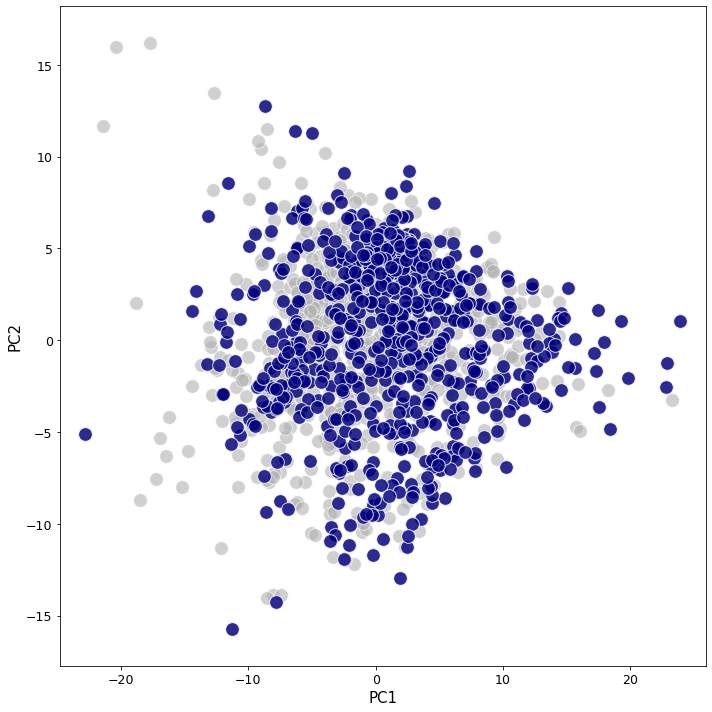

In [12]:
X_use = X_all_pca
X_ids = X_all_ids

X_subset = X_com_pca
X_subset_ids = X_com_ids

#X_subset_2 = X_sigma_pca
#X_subset_ids_2 = X_sigma_ids

f_ind_1 = 0 # which PC to plot
f_ind_2 = 1 # which PC to plot
x_min, x_max = X_use[:, f_ind_1].min() - 2, X_use[:, f_ind_1].max() + 2
y_min, y_max = X_use[:, f_ind_2].min() - 2, X_use[:, f_ind_2].max() + 2
plt.figure(figsize=(10,10))
extent = [x_min,x_max,y_min,y_max]
plt.xticks(fontsize=12.5) , plt.yticks(fontsize=12.5)
plt.xlabel(f"PC{f_ind_1+1}",fontsize=15), plt.ylabel(f"PC{f_ind_2+1}",fontsize=15)
plt.locator_params(axis='y', nbins=10), plt.locator_params(axis='x', nbins=10)
plt.xlim(x_min,x_max), plt.ylim(y_min,y_max) 
plt.scatter(X_use[:,f_ind_1], X_use[:,f_ind_2],c='#B1B1B1',alpha=0.6,marker=".",s=750,edgecolor='white')

### plot a colormap for the main set using descriptor values(comment out line above)
#vburmap = (compinp["sambvca_pvbur_35.min"] > 55).loc[(inp2["COM"]==1) & (inp2["PC"] == 1)]
#cMap_vbur = ListedColormap(['black', '#990000', ])
#plt.scatter(X_use[:,f_ind_1], X_use[:,f_ind_2],c=-vburmap,cmap=cMap_vbur,alpha=0.5,marker="s",s=10) 
#cbar = plt.colorbar()

### plot labels for main set
#for i in range(0,len(X_use)):
#    plt.text(X_use[i,f_ind_1],X_use[i,f_ind_2]," "+str(X_ids[i]),color="blue",fontsize=10,ha="left") 

### plot a subset(s)
plt.scatter(X_subset[:,f_ind_1], X_subset[:,f_ind_2],c='#000080',alpha=0.8,marker=".",s=750,edgecolor='white')
#plt.scatter_2(X_subset[:,f_ind_1], X_subset_2[:,f_ind_2],c="red",alpha=0.75,marker=".",s=150,edgecolor="white")

### plot labels for subset
#for i in range(0,len(X_subset)):
#    plt.text(X_subset[i,f_ind_1],X_subset[i,f_ind_2]," "+str(X_subset_ids[i]),color="red",fontsize=10,ha="right") 

### highlight an individual sample
#sample1 = 69 # 0-indexed
#plt.scatter(X_use[sample1,f_ind_1], X_use[sample1,f_ind_2],c="red",alpha=1,marker="D",edgecolor='black',s=150) 

plt.tight_layout()
#plt.show()
#plt.savefig("5 genchosenpca on all.png",dpi=300)

**Colorcode 2D PC score plot by descriptor**

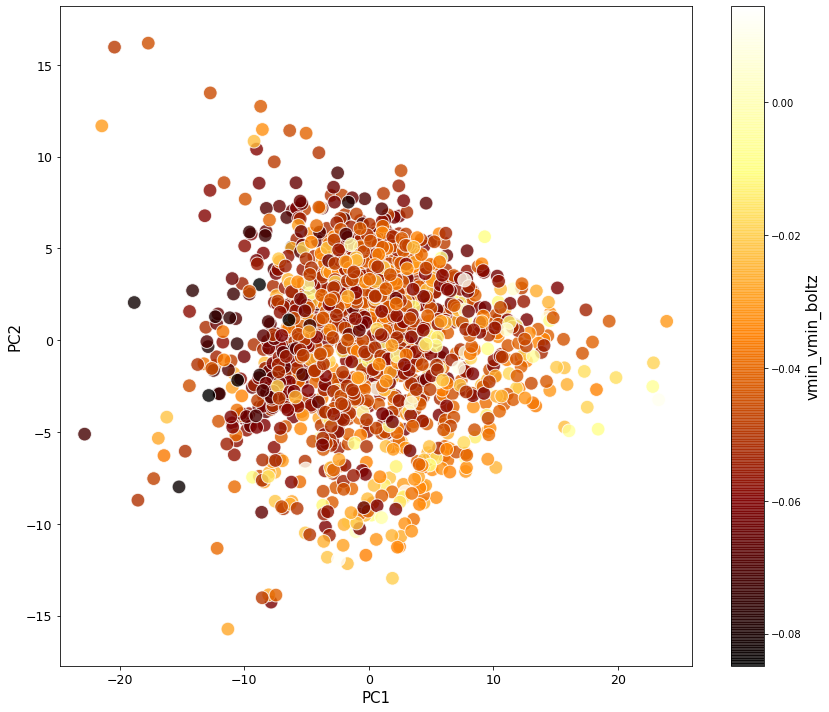

In [16]:
prop = 0           # the descriptor to use (0-indexed)

f_ind_1 = 0
f_ind_2 = 1
x_min, x_max = X_use[:, f_ind_1].min() - 2, X_use[:, f_ind_1].max() + 2
y_min, y_max = X_use[:, f_ind_2].min() - 2, X_use[:, f_ind_2].max() + 2
plt.figure(figsize=(12,10))
extent = [x_min,x_max,y_min,y_max]
plt.xticks(fontsize=12.5) 
plt.yticks(fontsize=12.5)
plt.xlabel(f"PC{f_ind_1+1}",fontsize=15)
plt.ylabel(f"PC{f_ind_2+1}",fontsize=15)
plt.locator_params(axis='y', nbins=10)
plt.locator_params(axis='x', nbins=10)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)

mapping = X_all[:,prop]                            # change this to X_all, X_com etc.
#mapping = [min([i,0]) for i in X_all[:,0]]        # optional capping (at 0)

cMap = "afmhot"
plt.scatter(X_use[:,f_ind_1], X_use[:,f_ind_2],c=mapping,cmap=cMap,alpha=0.8,marker=".",s=750,edgecolor='white') 
cbar = plt.colorbar()
cbar.set_label(f'{compinp.columns[prop]}', rotation=90,size=15)
plt.tight_layout()
#plt.savefig("property_plot.png",dpi=300)
plt.show()

**3D score plot**

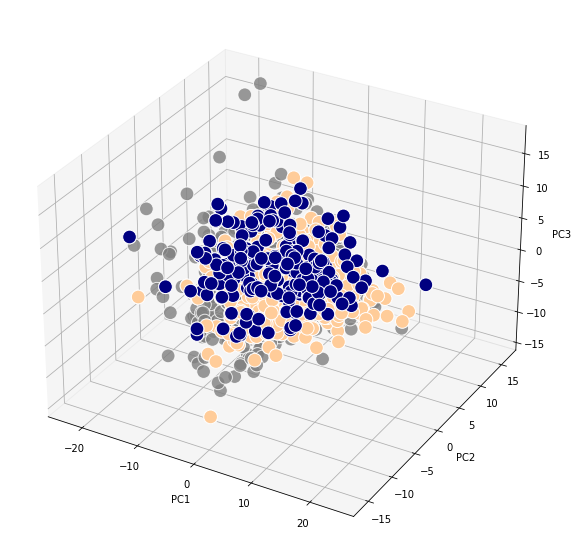

In [17]:
#%matplotlib notebook

X_use = X_all_pca
X_ids = X_all_ids

X_subset = X_com_pca
X_subset2 = X_sigma_pca

np.random.seed(19680801)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_use[:,0],X_use[:,1],X_use[:,2],c='grey',alpha=0.8,marker=".",s=750,edgecolor='white')

### plot subset as one color
#ax.scatter(X_subset[:,0],X_subset[:,1],X_subset[:,2],c="blue",alpha=1,marker=".",s=150,edgecolor="white",linewidth=0.5)

### plot subset using colormap
#mapping = X_screen_results
#cMap = "jet"
#ax.scatter(X_subset[:,0],X_subset[:,1],X_subset[:,2],c=mapping,cmap=cMap,alpha=1,marker=".",s=750,edgecolor="white")

### plot multiple subsets
ax.scatter(X_subset[:,0],X_subset[:,1],X_subset[:,2],c='#FFCC99',alpha=1,marker=".",s=750,edgecolor="white")
ax.scatter(X_subset2[:,0],X_subset2[:,1],X_subset2[:,2],c='#000080',alpha=1,marker=".",s=750,edgecolor="white")

ax.xaxis.pane.set_color('black'), ax.yaxis.pane.set_color('black'), ax.zaxis.pane.set_color('black')
ax.xaxis.pane.set_alpha(0.04), ax.yaxis.pane.set_alpha(0.04), ax.zaxis.pane.set_alpha(0.04) # with set_color = 'black, set_alpha = 0.04 gives a  light grey
#ax.grid(False) # get rid of the grid
ax.set_xlabel('PC1'), ax.set_ylabel('PC2'), ax.set_zlabel('PC3')
#plt.savefig("3D_PCA.png",dpi=300)
plt.show()

**Rotating 3D score plot**

In [ ]:
%matplotlib notebook

np.random.seed(19680801)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_use[:,0],X_use[:,1],X_use[:,2],c='grey',alpha=0.8,marker=".",s=500,edgecolor='white')
ax.scatter(X_subset[:,0],X_subset[:,1],X_subset[:,2],c='#000080',alpha=1,marker=".",s=500,edgecolor="white")

ax.xaxis.pane.set_color('black'),ax.yaxis.pane.set_color('black'),ax.zaxis.pane.set_color('black')
ax.xaxis.pane.set_alpha(0.07),ax.yaxis.pane.set_alpha(0.07),ax.zaxis.pane.set_alpha(0.07)
#ax.grid(False) # get rid of the grid
ax.set_xlabel('PC1'),ax.set_ylabel('PC2'),ax.set_zlabel('PC3')
plt.show()
def rotate(angle):
    ax.view_init(azim=angle)
rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0,362,2),interval=150)
#rot_animation.save('pca 3d rotation.gif', dpi=80, writer='imagemagick')